In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torchlens as tl # a library to get activations from network

# Understanding Grokking through Correlation Structure

Adam Shai, 2023.01.21

This work follows up on the transformer grokking work, focussing on the example of modular addition in a 1 layer transformer network. 
I want to study the correlation structure between the activations in the network across the different possible inputs. This example is useful
because we can easily enumerate all the different possible inputs and get the network activations completely.

The correlation analysis is inspired by work in neuroscience analysing information processing and sensory representation, especially in the cortex, in large populations of neurons (in neuroscience large means ~100-10,000 neurons). There are a number of interesting things to say about the situation in neuroscience vs. deep learning and the use of studying correlations, but I'll leave that for another time.

Let's see if we can get a handle on grokking through studying correlation structure!

## Recreating the grokking results for modular addition

Below is my code to recreate the results of the grokking work for modular addition. We save the state of the network every 10 epochs during training. We get nice grokking results. We've saved all the data in `training_dict.pt` if you don't want to train from scratch. It took ~15 minutes using my GPU.

### Network, training, and data hyperparameters

In [2]:
 # we are going to do modular addition
# our task is to take inputs a,b \in {0,...,P-1} for some prime P and predict a+b mod P, call the result c
# input is of the form "a b = c"
# hyperparameters
P = 113 # the prime number
d_vocab = P+1 # the size of the vocabulary, add one for = sign
d_model = 128 # the width of the residual streal (embedding dimension)
d_head = 32 # the width of each head, 4 of them
d_mlp = 512 # the width of the feed forward layer
input_size = 3 # the length of the context, a, b, and =

# training params
training_percent = 0.4
learning_rate = 0.001
lam = 1.
epochs = 40000

# generate all possible a,b,c triples, there should be 113*113 of them
# we will use these to train the model
# keep these all in a torch tensor of size (113*113, 4)
torch.manual_seed(0)
triples = torch.zeros((P*P, 4), dtype=torch.long)
for i in range(P):
    for j in range(P):
        triples[i*P+j, 0] = i
        triples[i*P+j, 1] = j
        triples[i*P+j, 2] = P
        triples[i*P+j, 3] = (i+j)%P

# use 30% of the data for training, 70% for validation
# randomly choose the 30 percent
train_size = int(training_percent*len(triples))
data_size = len(triples)
inds = torch.randperm(data_size)
train_indices = inds[:train_size]
val_indices = inds[train_size:]
train_data = triples[train_indices]
val_data = triples[val_indices]

# make sure theres no overlap between train and val
assert len(set(train_indices).intersection(set(val_indices))) == 0

print("the number of training examples is", len(train_data))
print("the number of validation examples is", len(val_data))
print("total number of examples is", len(train_data)+len(val_data))
print("here are some examples of training data")
print(train_data[:10])


the number of training examples is 5107
the number of validation examples is 7662
total number of examples is 12769
here are some examples of training data
tensor([[ 37,   1, 113,  38],
        [ 23,   9, 113,  32],
        [  2,  43, 113,  45],
        [  7,  34, 113,  41],
        [ 42, 101, 113,  30],
        [ 81,  71, 113,  39],
        [ 55,  12, 113,  67],
        [  1,   3, 113,   4],
        [ 46,  78, 113,  11],
        [ 18,  18, 113,  36]])


### The Simple Transformer

This should be pretty straightforward. Hopefully I didn't mess anything up! At least it seems to learn.

In [3]:
class Head(nn.Module):
    def __init__(self, d_head):
        super().__init__()
        self.W_Q = nn.Linear(d_model, d_head, bias=False)
        self.W_K = nn.Linear(d_model, d_head, bias=False)
        self.W_V = nn.Linear(d_model, d_head, bias=False)
        self.W_O = nn.Linear(d_head, d_head, bias=False)
        self.register_buffer("mask", torch.tril(torch.ones(input_size, input_size)))

    def forward(self, x):
        # x is of size (batch_size, input_size, d_model)
        # get the query, key, and value
        Q = self.W_Q(x) # (batch_size, input_size, d_head)
        K = self.W_K(x) # (batch_size, input_size, d_head)
        V = self.W_V(x) # (batch_size, input_size, d_head)
        # get the attention weights
        A = torch.einsum("bid,bjd->bij", Q, K) / (d_head**0.5) 
        A = A.masked_fill(self.mask==0, float("-inf"))
        A = F.softmax(A, dim=-1) # the rows of A sum to 1
        # apply the attention weights
        O = torch.einsum("bij,bjd->bid", A, V) # this is the output of the attention head, we weight the values by the attention weights
        O = self.W_O(O) # (batch_size, input_size, d_model)
        return O 
    
class MLP(nn.Module):
    def __init__(self, d_model, d_mlp):
        super().__init__()
        self.W_in = nn.Linear(d_model, d_mlp)
        self.W_out = nn.Linear(d_mlp, d_model)
        
    def forward(self, x):
        # x is of size (batch_size, input_size, d_model)
        x = self.W_in(x) # (batch_size, input_size, d_mlp)
        x = F.relu(x)
        x = self.W_out(x) # (batch_size, input_size, d_model)
        return x

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(d_vocab, d_model)
        self.pos_embedding = nn.Embedding(input_size, d_model)
        self.heads = nn.ModuleList([Head(d_head) for _ in range(4)])
        self.mlp = MLP(d_model, d_mlp)
        self.unembedding = nn.Linear(d_model, d_vocab)

    def forward(self, x):
        # x is of size (batch_size, input_size)
        # embed the input
        x = self.embedding(x) + self.pos_embedding(torch.arange(input_size, device=x.device))
        # apply the attention heads, stack them
        x = x + torch.cat([head(x) for head in self.heads], dim=-1) # (batch_size, input_size, d_model)
        # apply the MLP
        x = x + self.mlp(x)
        # unembed the output
        x = self.unembedding(x)
        return x


### Training
Change the `TRAIN` variable to True if you want to rerun training

In [4]:
TRAIN = False
import copy

# make a training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model().to(device)

# train on all the training data
x = train_data[:, :input_size].to(device)
y = train_data[:, -input_size:].to(device) # (batch_size, input_size)

x_val = val_data[:, :input_size].to(device)
y_val = val_data[:, -input_size:].to(device) # (batch_size, input_size)

# make a function that evaluates the loss on both the training and validation data
@torch.no_grad()
def evaluate_loss(model):
    model.eval()
    # training data
    logits = model(x) # (batch_size, input_size, d_vocab)
    logits, y_last = logits[:, -1], y[:, -1] # (batch_size, d_vocab), (batch_size,)
    train_loss = F.cross_entropy(logits, y_last, reduction="mean")
    train_acc = (torch.argmax(logits, dim=-1) == y_last).float().mean()
    # validation data
    logits = model(x_val) # (batch_size, input_size, d_vocab)
    logits, y_val_last = logits[:, -1], y_val[:, -1] # (batch_size, d_vocab), (batch_size,)
    val_loss = F.cross_entropy(logits, y_val_last, reduction="mean")
    val_acc = (torch.argmax(logits, dim=-1) == y_val_last).float().mean()
    model.train() # put the model back in training mode
    return train_loss, train_acc, val_loss, val_acc

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=lam)#, betas = (0.9, 0.98))

if TRAIN:
    # a dictionary to store the training and validation losses
    training_dict = {}
    training_dict["train_data"] = train_data
    training_dict["val_data"] = val_data
    pbar = tqdm(range(epochs))
    for epoch in pbar:
        # get the predictions
        preds = model(x) # (batch_size, input_size, d_vocab)
        # we only care about the last prediction
        preds = preds[:, -1] # (batch_size, d_vocab)
        y_last = y[:, -1] # (batch_size,)
        loss = F.cross_entropy(preds, y_last, reduction="mean")
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        
        # print the loss and epoch
        if epoch%10==0:
            train_loss, train_acc, val_loss, val_acc = evaluate_loss(model)
            # print the loss and accuracy, with two decimal places, add to the pbar
            pbar.set_description(f"Epoch: {epoch}, Train Loss: {train_loss:.8f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
            # keep track of these values in a dictionary
            # add learning rat to end of pbar
            pbar.set_postfix({"lr": optimizer.param_groups[0]["lr"]})
            training_dict[epoch] = {"train_loss": train_loss, "train_acc": train_acc, "val_loss": val_loss, "val_acc": val_acc}
            # add the model parameters to the training dict, deepcopy to avoid memory issues
            training_dict[epoch]["model"] = copy.deepcopy(model.state_dict())


    # save the training dict
    torch.save(training_dict, "training_dict.pt")

        


In [5]:
torch.save(training_dict, "training_dict.pt")

NameError: name 'training_dict' is not defined

In [6]:
# get the embedding matrix
embedding_matrix = model.embedding.weight.detach().cpu().numpy()

# get the output of the mlp
mlp_output = model.mlp.W_out.weight.detach().cpu().numpy()

# get the output of the unembedding layer
unembedding_matrix = model.unembedding.weight.detach().cpu().numpy()

# print the shape of each of these
print(embedding_matrix.shape)
print(mlp_output.shape)
print(unembedding_matrix.shape)

(114, 128)
(128, 512)
(114, 128)


### Load the training results

In [7]:
# clear cuda memory
torch.cuda.empty_cache()


# load training dict .pt file
training_dict = torch.load("training_dict.pt")
# move everything in the training dictionary to the cpu
# the structure of the training dict is:
# training_dict[epoch] = {"train_loss": train_loss, "train_acc": train_acc, "val_loss": val_loss, "val_acc": val_acc}
# training_dict[epoch]["model"] = model.state_dict()
for epoch in training_dict:
    if type(epoch) == int:
        for key in training_dict[epoch]:
            if type(training_dict[epoch][key]) == torch.Tensor:
                training_dict[epoch][key] = training_dict[epoch][key].cpu()

# get the training and validation data
train_data = training_dict["train_data"] # (batch_size, input_size)
val_data = training_dict["val_data"] # (batch_size, input_size)


### We see Grokking!

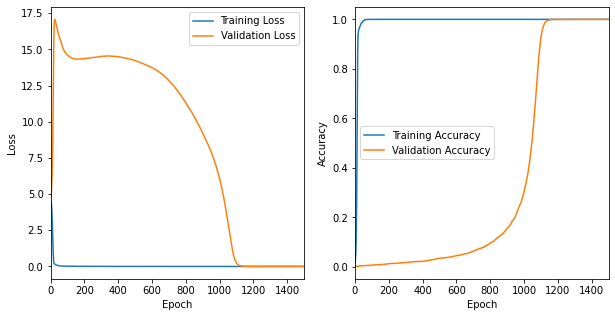

In [8]:
# plot the training loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot([training_dict[epoch]["train_loss"] for epoch in training_dict if type(epoch) == int], label="Training Loss")
plt.plot([training_dict[epoch]["val_loss"] for epoch in training_dict if type(epoch) == int], label="Validation Loss")
plt.xlim([0,1500])
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.subplot(1, 2, 2)
plt.plot([training_dict[epoch]["train_acc"] for epoch in training_dict if type(epoch) == int], label="Training Accuracy")
plt.plot([training_dict[epoch]["val_acc"] for epoch in training_dict if type(epoch) == int], label="Validation Accuracy")
plt.xlim([0,1500])
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()


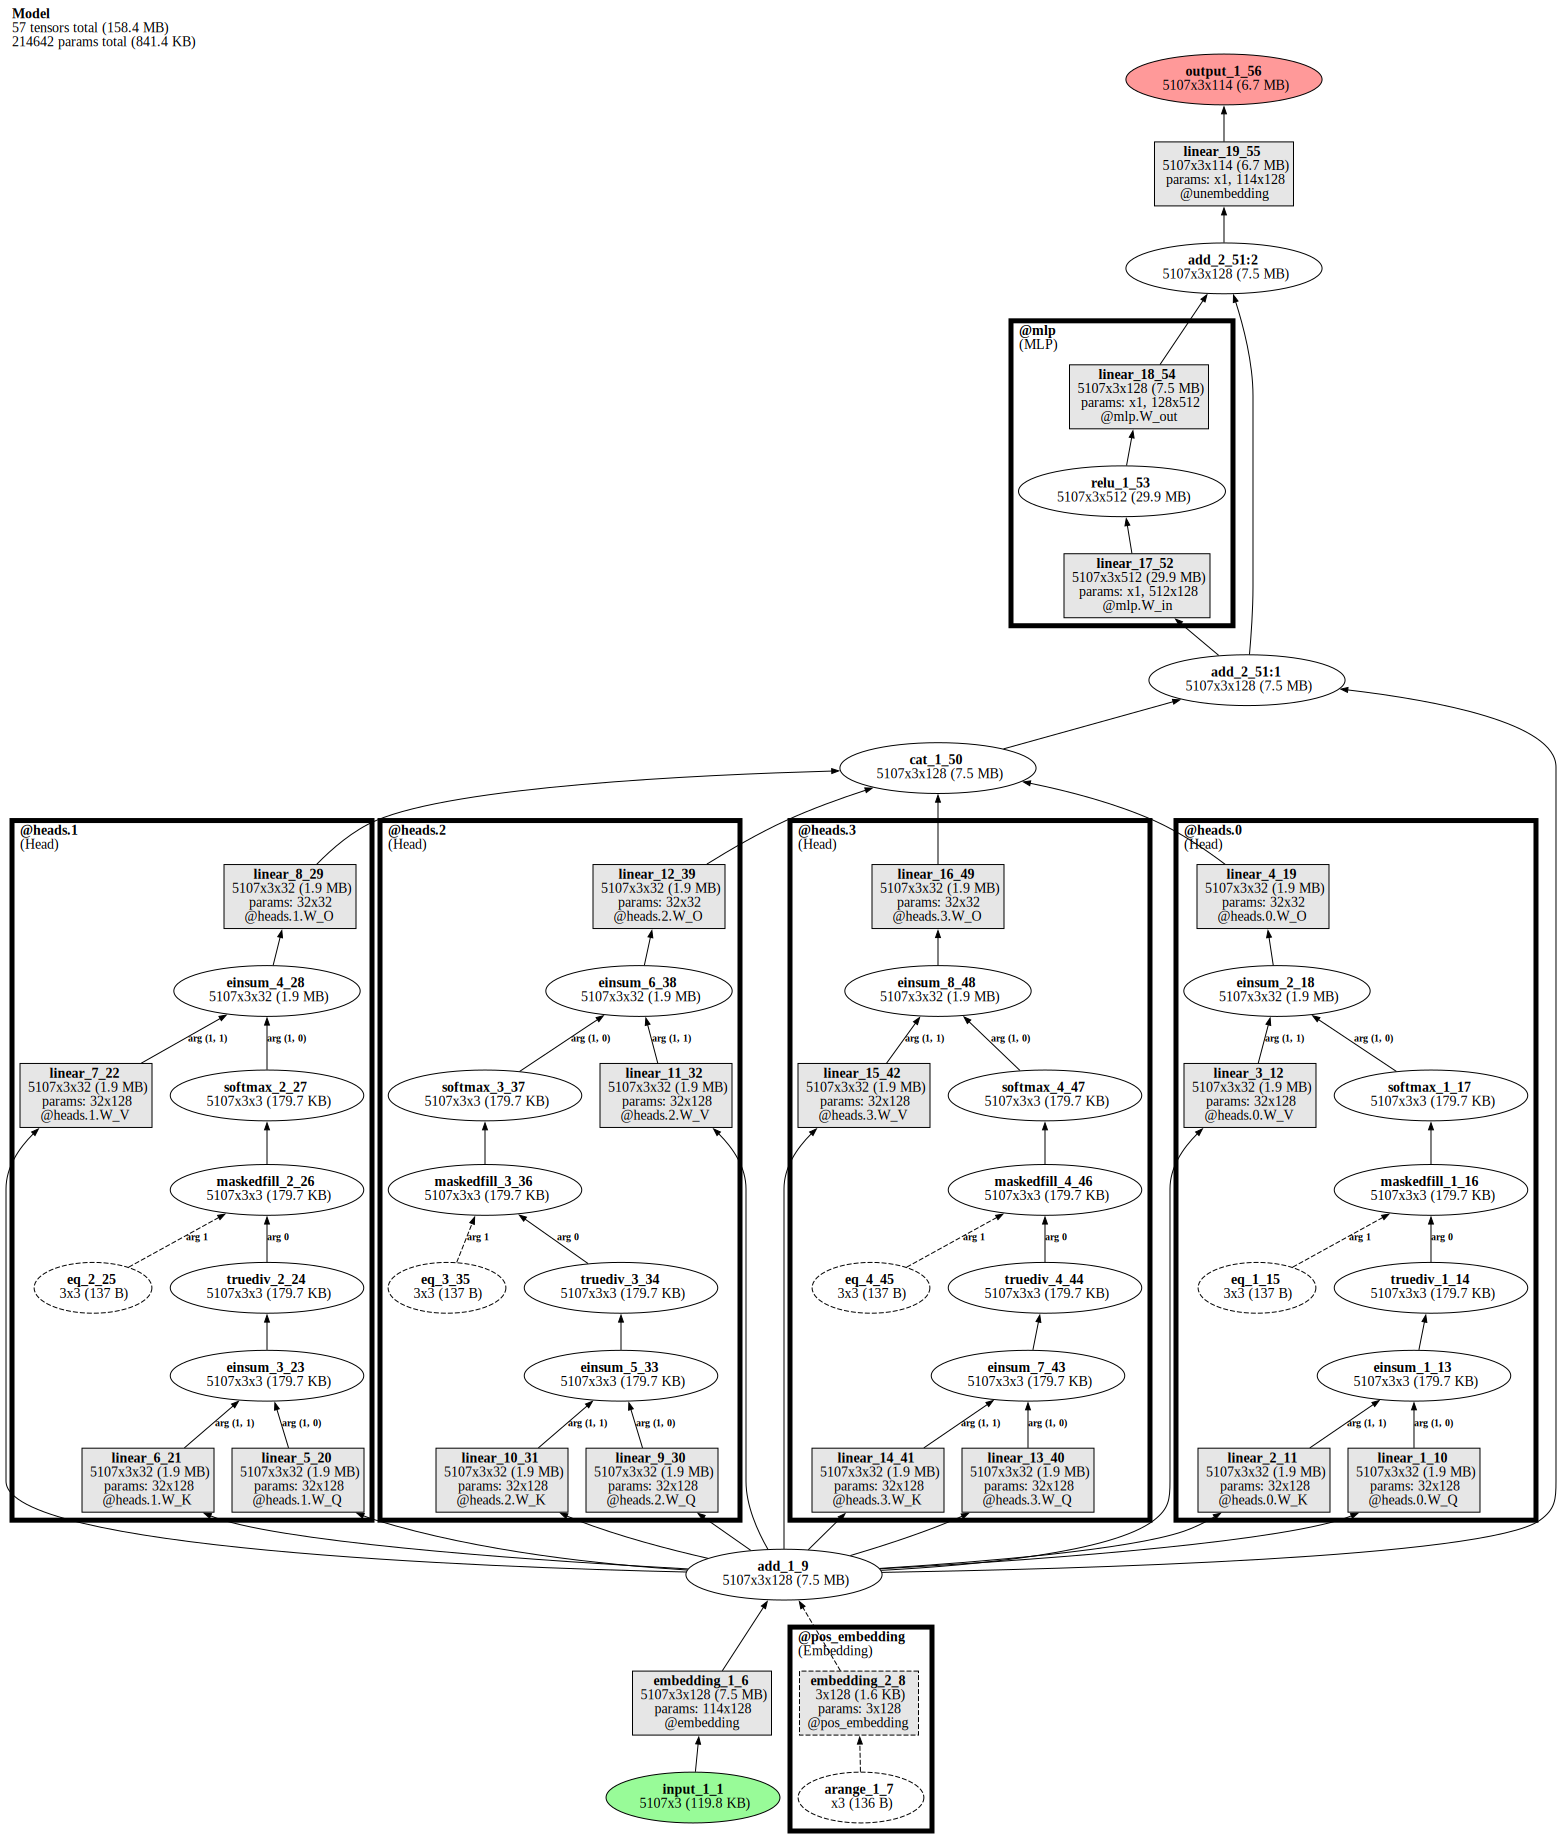

In [9]:
# get the layers for the model
model = Model().to(device)
tl.show_model_graph(model, x)

In [12]:
# print all the avaialble epochs in the training dict, we are only interested in epochs up to a value of 15000
epochs = [epoch for epoch in training_dict if type(epoch) == int and epoch <= 1500]
# only keep epochs that are divisible by 1000
epochs = [epoch for epoch in epochs if epoch%50==0]

print('hi', epochs)
# loop through each of the epochs and get the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# use tqdm
pbar = tqdm(epochs)
W_E = {}

# combine x and x_val and keep track of the indices
device = "cpu"

x = torch.cat([x, x_val], dim=0).to(device)
train_inds = torch.arange(x.shape[0]-x_val.shape[0])
val_inds = torch.arange(x.shape[0]-x_val.shape[0], x.shape[0])
print(x.shape)
for epoch in pbar:
    model = Model().to(device)
    model.load_state_dict(training_dict[epoch]["model"])
    model.eval()
    acts = tl.get_model_activations(model, x, which_layers='all')
    W_E[epoch] = acts
    del model
    


hi [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500]


  0%|          | 0/31 [00:00<?, ?it/s]

torch.Size([20431, 3])


In [44]:
import numpy as np
model_part = {'embed':'add_1_9', 'attn_out':'cat_1_50', 'mlp_out':'linear_18_54'}

# make a function that takes in a model_part key and returns covs and var_expl
# for each epoch
def get_covs_and_var_expl(part, epoch, trial_type=None):

    if part=='attn':
        # then we want to get the activations for all attn_softmax layers
        # get the layer names
        layer_names = [model_part['attn_softmax1'], model_part['attn_softmax2'],
                          model_part['attn_softmax3'], model_part['attn_softmax4']]
        # get the acts for the layer
        layer_acts = [W_E[epoch][layer_name].tensor_contents for layer_name in layer_names]
        layer_acts = np.concatenate(layer_acts, axis=1)
    else:
        # get the layer name
        layer_name = model_part[part]
        # get the acts for the layer
        layer_acts = W_E[epoch][layer_name].tensor_contents # (trials, input_size, d_model)


    if trial_type=='train':
        # get the train inds
        inds = train_inds
        # restrict activations
        layer_acts = layer_acts[inds]
    elif trial_type=='val':
        # get the val inds
        inds = val_inds
        # restrict activations
        layer_acts = layer_acts[inds]

    if epoch == 0:
        print("size of activations is:", layer_acts.shape)
        
    trials, input_size, d_model = layer_acts.shape
    n_neurons = input_size*d_model
    layer_acts = layer_acts.reshape(trials, n_neurons)

    # normalize the layer acts for each neuron individually, zscore
    layer_acts = (layer_acts - layer_acts.mean(axis=0))/layer_acts.std(axis=0)
    # make sure infinities and nans are set to 0
    layer_acts[np.isnan(layer_acts)] = 0
    layer_acts[np.isinf(layer_acts)] = 0
    # compute the covariance matrix
    covs = np.cov(layer_acts, rowvar=False)
    # compute the variance explained per PC
    var_expl = np.linalg.svd(covs, compute_uv=False)
    var_expl = var_expl/np.sum(var_expl)
    return covs, var_expl

# make a function that gets the covs and var_expl for each epoch
# make a loop over epochs and use the function above
def get_covs_and_var_expl_all_epochs(part, trial_type=None):

    epochs = [epoch for epoch in W_E]
    # make a list of covs and var_expl
    covs = []
    var_expl = []
    # return a dict indexed by epoch
    var_dict = {}
    cov_dict = {}
    # loop over epochs
    for epoch in epochs:
        cov, var = get_covs_and_var_expl(part, epoch, trial_type)
        cov_dict[epoch] = cov
        var_dict[epoch] = var
    return cov_dict, var_dict




# do this for all model_parts and save the results in a dict
# do this for None, train, and val. use model_part keys
trial_types = ['all', 'train', 'val']
model_parts = ['embed', 'attn_out', 'mlp_out']
covs = {}
var_expl = {}
for trial_type in trial_types:
    covs[trial_type] = {}
    var_expl[trial_type] = {}
    print("trial type is:", trial_type)
    for mp in model_parts:
        print("model part is:", mp)
        covs[trial_type][mp], var_expl[trial_type][mp] = get_covs_and_var_expl_all_epochs(mp, trial_type)

trial type is: all
model part is: embed
size of activations is: torch.Size([20431, 3, 128])


C:\Users\adamimos\AppData\Local\Temp\ipykernel_1028\4095858583.py:44: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:1273.)
  layer_acts[np.isnan(layer_acts)] = 0
C:\Users\adamimos\AppData\Local\Temp\ipykernel_1028\4095858583.py:45: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:1273.)
  layer_acts[np.isinf(layer_acts)] = 0


model part is: attn_out
size of activations is: torch.Size([20431, 3, 128])
model part is: mlp_out
size of activations is: torch.Size([20431, 3, 128])
trial type is: train
model part is: embed
size of activations is: torch.Size([12769, 3, 128])
model part is: attn_out
size of activations is: torch.Size([12769, 3, 128])
model part is: mlp_out
size of activations is: torch.Size([12769, 3, 128])
trial type is: val
model part is: embed
size of activations is: torch.Size([7662, 3, 128])
model part is: attn_out
size of activations is: torch.Size([7662, 3, 128])
model part is: mlp_out
size of activations is: torch.Size([7662, 3, 128])


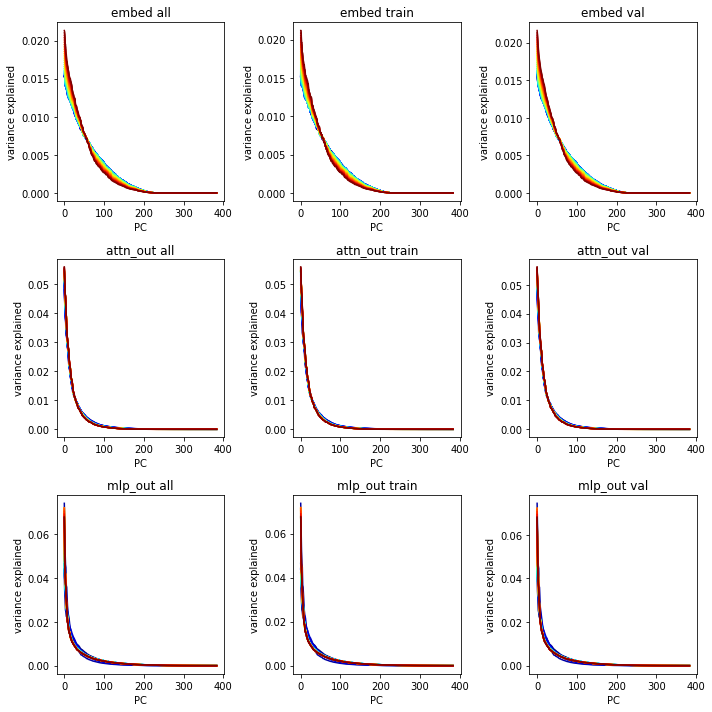

In [45]:
# we want to plot the variance explained for each epoch for each model part over all data, train, and validation sets
# use the var_explained dict
# each plot should have PCs on the x-axis and variance explained on the y-axis
# with a different curve for each epoch
# have 3 columns and 3 rows, where the rows are the different parts of the model
# and the columns are the different trial types
# make sure the colors of the lines are continous across epochs

f = plt.figure(figsize=(10, 10))
for i, mp in enumerate(model_parts):
    for j, trial_type in enumerate(trial_types):
        ax = f.add_subplot(3, 3, i*3+j+1)
        colors = plt.cm.jet(np.linspace(0, 1, len(epochs)))
        for k, epoch in enumerate(epochs):
            ax.plot(var_expl[trial_type][mp][epoch], color=colors[k], label=epoch)
        ax.set_title(mp + ' ' + trial_type)
        ax.set_xlabel('PC')
        ax.set_ylabel('variance explained')
plt.tight_layout()
plt.show()

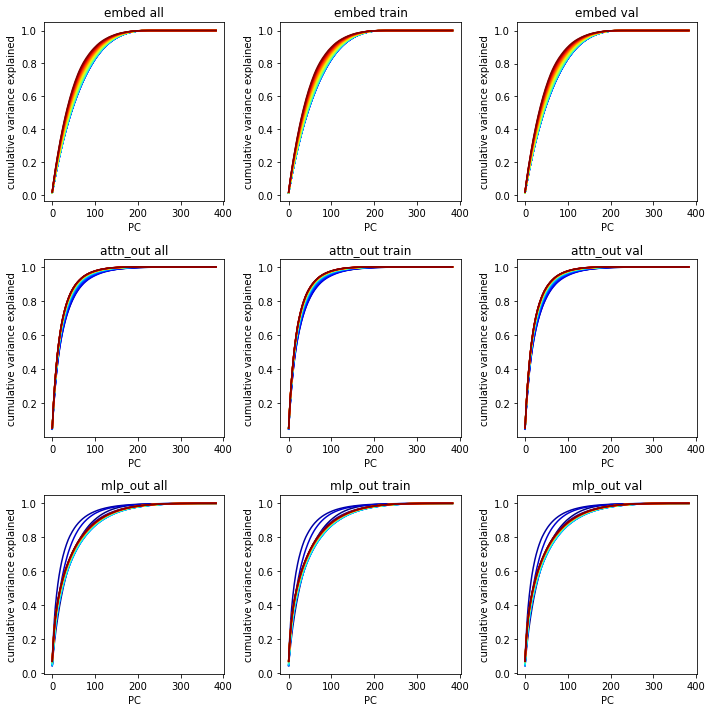

In [58]:
# make the same plot as above but for cumulative variance explained
# make sure the colors of the lines are continous across epochs
# also make sure there is a colorbar
f = plt.figure(figsize=(10, 10))
for i, mp in enumerate(model_parts):
    for j, trial_type in enumerate(trial_types):
        ax = f.add_subplot(3, 3, i*3+j+1)
        colors = plt.cm.jet(np.linspace(0, 1, len(epochs)))
        for k, epoch in enumerate(epochs):
            ax.plot(np.cumsum(var_expl[trial_type][mp][epoch]), color=colors[k], label=epoch)
        ax.set_title(mp + ' ' + trial_type)
        ax.set_xlabel('PC')
        ax.set_ylabel('cumulative variance explained')
        # add a colorbar
        # make sure the colors of the lines are continous across epochs
        
plt.tight_layout()
plt.show()

# add a colorbar to the plot above
# make sure the colors of the lines are continous across epochs


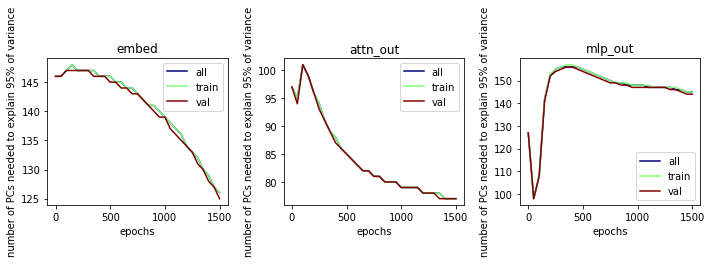

In [56]:
# make a similar type of plot, but now show how many PCs are needed to explain 95% of the variance
# for each epoch and each trial type, in this case we need 3 plots, with 3 columns and 1 row
# each column will be a different model part, and each figure will have 3 curves, one for each trial type
# make the colors by trial type

f = plt.figure(figsize=(10, 3))
for i, mp in enumerate(model_parts):
    ax = f.add_subplot(1, 3, i+1)
    colors = plt.cm.jet(np.linspace(0, 1, len(trial_types)))
    for j, trial_type in enumerate(trial_types):
        n_pcs = []
        for epoch in epochs:
            n_pcs.append(np.where(np.cumsum(var_expl[trial_type][mp][epoch])>0.95)[0][0])
        ax.plot(epochs, n_pcs, color=colors[j], label=trial_type)
    ax.set_title(mp)
    ax.set_xlabel('epochs')
    ax.set_ylabel('number of PCs needed to explain 95% of variance')
    # add legend
    ax.legend()
plt.tight_layout()
plt.show()
# add legend




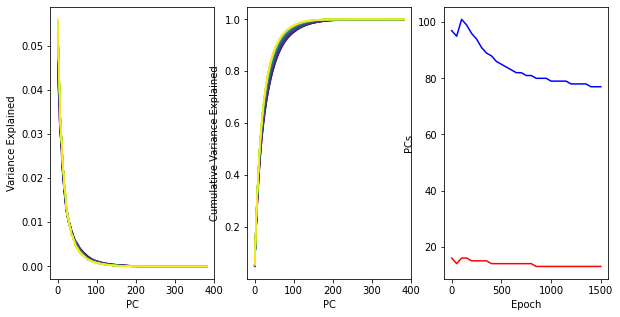

In [28]:
# plot the variance explained for embed with PC on x axis
# and each epoch a different color line, continously varying
# from blue to red, use a for loop, plot cumsum of var_expl in next column
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
colors = np.linspace(0, 1, len(var_expl_embed))
for i, epoch in enumerate(var_expl_embed):
    plt.plot(var_expl_embed[epoch], color=plt.cm.viridis(colors[i]))
plt.xlabel("PC")
plt.ylabel("Variance Explained")
plt.subplot(1, 3, 2)
for i, epoch in enumerate(var_expl_embed):
    plt.plot(np.cumsum(var_expl_embed[epoch]), color=plt.cm.viridis(colors[i]))
plt.xlabel("PC")
plt.ylabel("Cumulative Variance Explained")
# in third column plot how many PCs are needed to explain 90% of the variance
plt.subplot(1, 3, 3)
PCs_95 = []
PCs_50 = []
for i, epoch in enumerate(var_expl_embed):
    PCs_95.append(np.where(np.cumsum(var_expl_embed[epoch])>0.95)[0][0])
    PCs_50.append(np.where(np.cumsum(var_expl_embed[epoch])>0.5)[0][0])
# x axis is epoch number, which is in the dict
x_plot = [epoch for epoch in var_expl_embed]
plt.plot(x_plot, PCs_95, color='blue')
plt.plot(x_plot, PCs_50, color='red')
plt.xlabel("Epoch")
plt.ylabel("PCs")
plt.show()



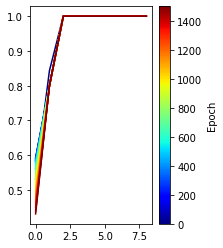

In [56]:
# now plot cumsum of variance explained
plt.subplot(1, 2, 2)
# get the epochs
epochs = [epoch for epoch in var_expl_embed]
colors =  plt.cm.jet(np.linspace(0,1,len(epochs)))
# loop over epochs
for i, epoch in enumerate(epochs):
    plt.plot(np.cumsum(var_expl_embed[epoch]), color=colors[i], label=epoch)

# add a colorbar as a legend
sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=0, vmax=epochs[-1]))
sm._A = []
plt.colorbar(sm, label="Epoch")


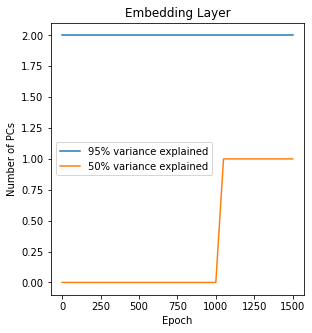

In [57]:
# now for each epoch, compute how many PCs to get to 95% variance explained
# and plot that as a line, x axis is epoch, y axis is number of PCs
# make a list of epochs, do this for 50% and 95% variance explained
epochs = [epoch for epoch in var_expl_embed]
# make a list of var_expl
var_expl = [var_expl_embed[epoch] for epoch in epochs]
# make a list of cumsums
cumsums = [np.cumsum(var_expl_embed[epoch]) for epoch in epochs]
# make a list of PCs to get to 95% variance explained
PCs_95 = [np.where(cumsum>0.95)[0][0] for cumsum in cumsums]
# make a list of PCs to get to 50% variance explained
PCs_50 = [np.where(cumsum>0.5)[0][0] for cumsum in cumsums]
# plot PCs to get to 95% variance explained
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, PCs_95, label="95% variance explained")
plt.xlabel("Epoch")
plt.ylabel("Number of PCs")
plt.title("Embedding Layer")
plt.legend()
# plot PCs to get to 50% variance explained
plt.plot(epochs, PCs_50, label="50% variance explained")
plt.xlabel("Epoch")
plt.ylabel("Number of PCs")
plt.title("Embedding Layer")
plt.legend()




TypeError: float() argument must be a string or a number, not 'dict'

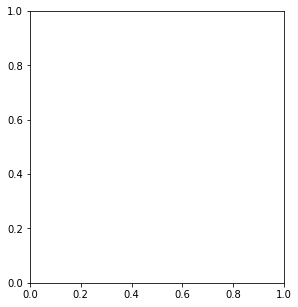

In [58]:
# plot vars_explained
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(var_expl_embed)
plt.xlabel("Epoch")
plt.ylabel("Variance Explained")
plt.subplot(1, 2, 2)
plt.plot(var_expl_embed)
plt.xlim([0, 1500])
plt.xlabel("Epoch")
plt.ylabel("Variance Explained")
plt.show()


In [59]:
# plot how many PCs to get to 95% variance explained
plt.figure(figsize=(10, 5))
# loop through each epoch
for i, epoch in enumerate(epochs):
    # get the number of PCs
    n_pcs = np.where(var_expl[epoch] >= 0.9)[0][0]
    plt.scatter(epoch, n_pcs, color=colors[i])
plt.xlabel("Epoch")
plt.ylabel("Number of PCs")
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

<Figure size 720x360 with 0 Axes>

In [ ]:
acts = tl.get_model_activations(model, x_val, which_layers='all')

************
Feature extraction failed; returning model and environment to normal
*************


UnboundLocalError: local variable 'output_tensors' referenced before assignment

Mean: -0.0089, Std: 0.0000


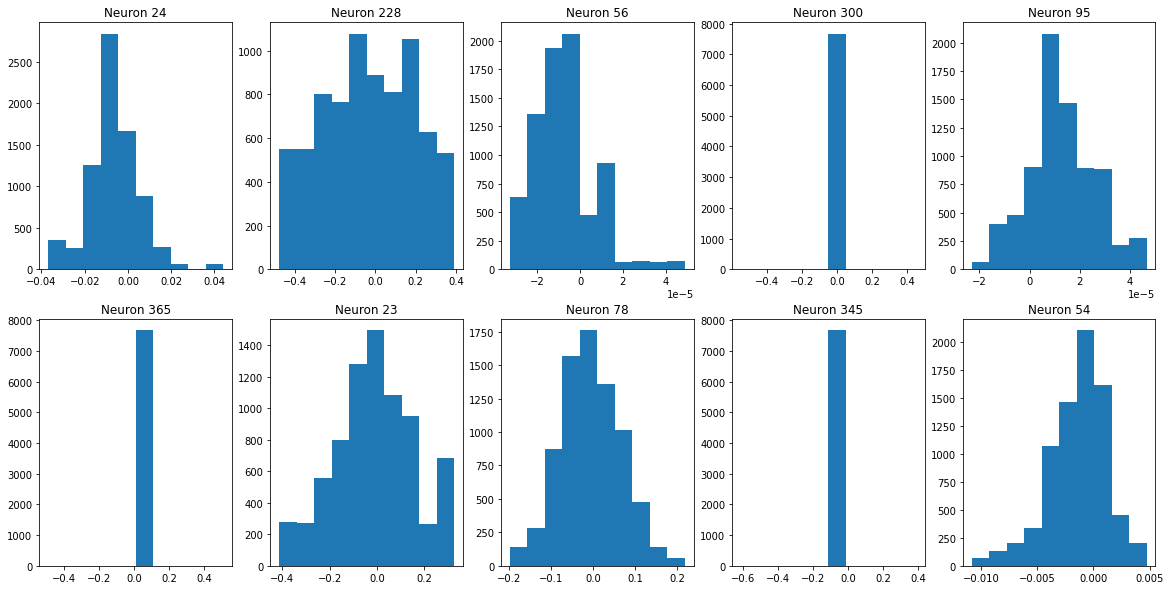

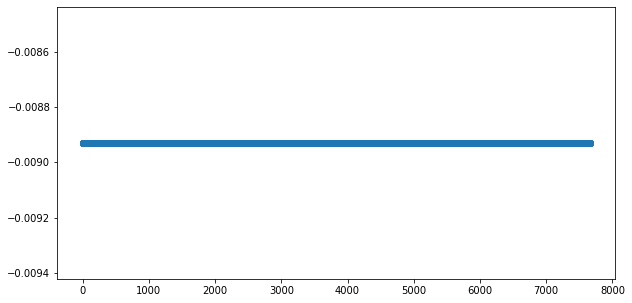

In [ ]:
# first lets focus on the embedding activations
embedding_acts = acts['add_1_9'].tensor_contents # (batch_size, input_size, d_model)
trials, input_size, d_model = embedding_acts.shape
n_neurons = input_size*d_model
# reshape the activations so we have (trials, n_neurons)
embedding_acts = embedding_acts.reshape(trials, -1)
# now plot some histograms of activity for like 5 random neurons over the trials
# we will use the torch
neuron_inds = torch.randint(0, n_neurons, (10,))
# loop through each of the neurons and plot the histogram
# do this in a 2x5 grid
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
for i, neuron_ind in enumerate(neuron_inds):
    # get the neuron activity
    neuron_act = embedding_acts[:, neuron_ind]
    # plot the histogram
    axs[i//5, i%5].hist(neuron_act)
    axs[i//5, i%5].set_title(f"Neuron {neuron_ind}")

# plot the values for neuron 362
neuron_ind = 362
neuron_act = embedding_acts[:, neuron_ind]
plt.figure(figsize=(10, 5))
plt.scatter(torch.arange(len(neuron_act)), neuron_act)
# print the mean and std of this neuron
print(f"Mean: {neuron_act.mean():.4f}, Std: {neuron_act.std():.4f}")

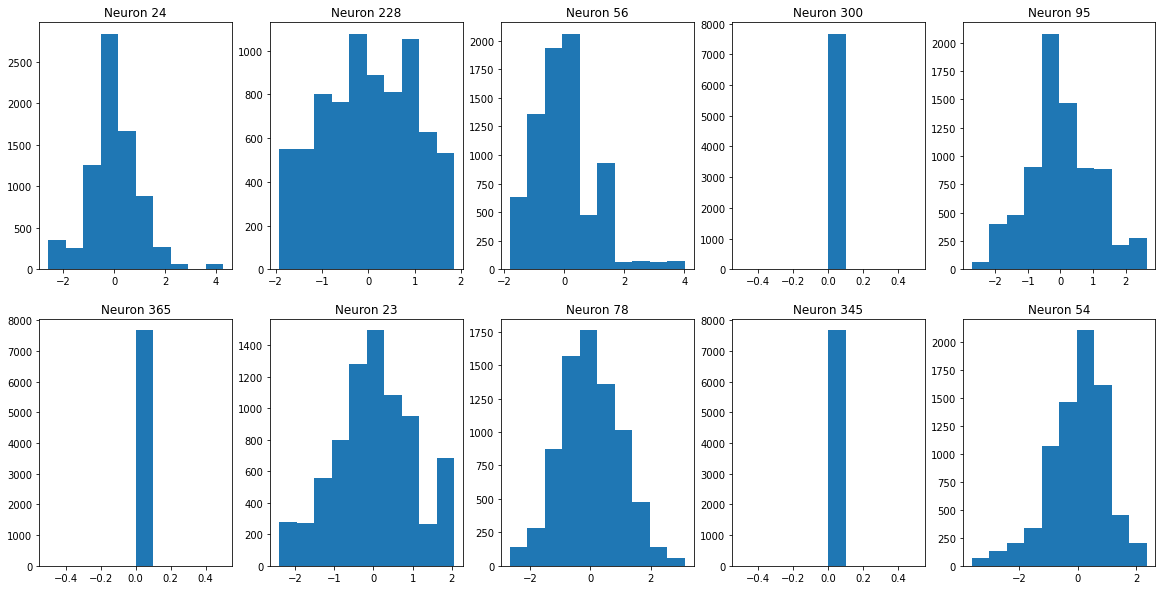

In [ ]:
# z-score each trial individually, across all trials
embedding_acts = (embedding_acts - embedding_acts.mean(0, keepdim=True))/embedding_acts.std(0, keepdim=True)
# if there are any nans, replace them with 0
embedding_acts[torch.isnan(embedding_acts)] = 0
# if there are any infinities, replace them with 0
embedding_acts[torch.isinf(embedding_acts)] = 0
# w replot the hiysts
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
for i, neuron_ind in enumerate(neuron_inds):
    # get the neuron activity
    neuron_act = embedding_acts[:, neuron_ind]
    # plot the histogram
    axs[i//5, i%5].hist(neuron_act)
    axs[i//5, i%5].set_title(f"Neuron {neuron_ind}")

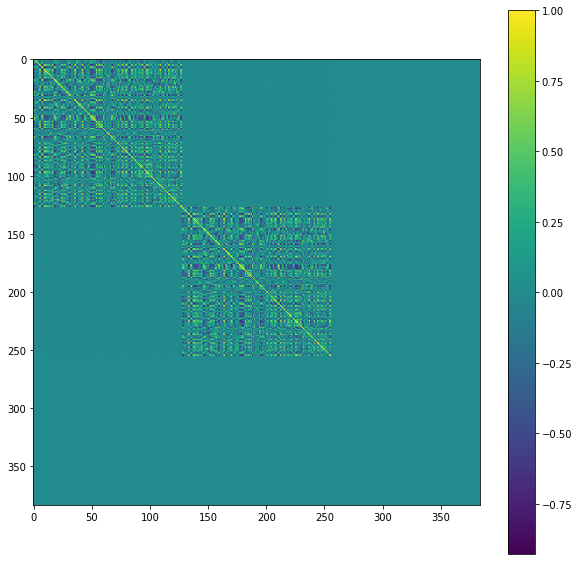

In [ ]:
import numpy as np
# now calculate the covariance matrix
cov_mat = np.cov(embedding_acts.T)
# replace 0 with Nan
# plot the correlation matrix
plt.figure(figsize=(10, 10))
plt.imshow(cov_mat)
plt.colorbar()


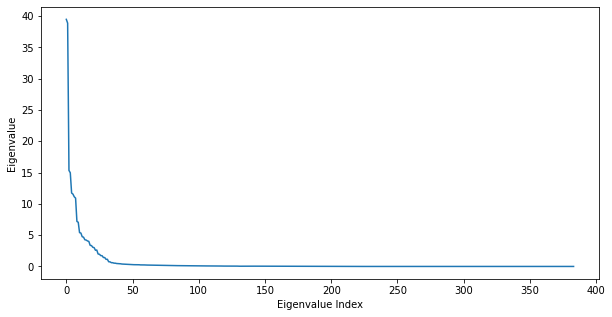

In [ ]:
# plot the eigenspectrum of the covariance matrix
plt.figure(figsize=(10, 5))
plt.plot(np.linalg.eigvals(cov_mat))
plt.xlabel("Eigenvalue Index")
plt.ylabel("Eigenvalue")
plt.show()

Text(0, 0.5, 'Variance Explained')

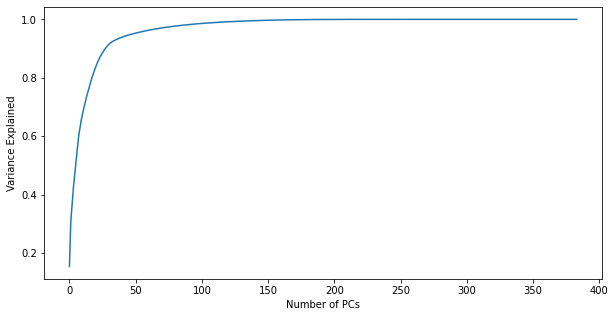

In [ ]:
# plot variance explained by PC
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(np.linalg.eigvals(cov_mat))/np.sum(np.linalg.eigvals(cov_mat)))
plt.xlabel("Number of PCs")
plt.ylabel("Variance Explained")